<a href="https://colab.research.google.com/github/safarie1103/Safarie1103/blob/master/Bellevue%20University/Courses/DSC550/Week9and10/how-toxic-are-hillary-and-trump-tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



I've been wanting to play with this dataset for a while. I've also been wanting to try to see how do models built on [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/) perform on non-competition "real world" data. Here I will just use one model that was built inside of a [kernel](https://www.kaggle.com/tunguz/bi-gru-lstm-cnn-poolings-fasttext). The kernel scores in the 0.984x AUC range. It's a respectable score, but well below the top solutions that scored in the 0.988x range. 

---- October 22 2018 Update - Added a few distribution plots and a more extensive lists of the most problematic tweets, 10 per topic. ----

---- October 31 2018 Update - Added a few clarifications and explanations. ----

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

import time
start_time = time.time()
from sklearn.model_selection import train_test_split
import sys, os, re, csv, codecs, numpy as np, pandas as pd
np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
#from keras.engine import InputSpec, Layer
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D

import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("."))

# Any results you write to the current directory are saved as output.

Now, let's load the data and all the vector embeddings. 

300-dimensional pretrained FastText English word vectors released by Facebook.

The first line of the file contains the number of words in the vocabulary and the size of the vectors. Each line contains a word followed by its vectors, like in the default fastText text format. Each value is space separated. Words are ordered by descending frequency.

In [3]:
import os
import sys
import gzip
import json
from pathlib import Path
import csv


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DataSet_Dir = '/content/drive/MyDrive/DataSets/'
DataSet_Dir = Path(DataSet_Dir)


Mounted at /content/drive


In [7]:
tweets = pd.read_csv(DataSet_Dir.joinpath('tweets.csv'))
embedding_path = DataSet_Dir.joinpath('crawl-300d-2M.vec')
tweets.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/t0...,{'media': [{'display_url': 'pic.twitter.com/t0...
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27T23:26:40,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'n...",NaN
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Q3...,{'media': [{'display_url': 'pic.twitter.com/Q3...
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN


In [8]:
tweets.shape

(6444, 28)

We see that there are a total of 6444 tweets, and as it will be shown below they are almost evenly distributed between Hillary and Trump. This may seem like a lot of tweets, but for text classification this would be a very small amount of data.

We will embed words from these tweets into a word-vector space using one of the previously trained word embeddings. Here we use a 300-dimensional vector space that comes curtesy of FastText. We will also limit the length of text to 220 words. This is an overkill for tweets, but for general purpose it is rather small text length. The original was aimed at much longer text sizes, and this was a reasonable length for those purposes. The best embedding that we used in Toxic limited length to 900 words.

In [9]:
embed_size = 300
max_features = 130000
max_len = 220

tweets["text"].fillna("no comment")
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
raw_text = tweets["text"].str.lower()


In order for our pretrained models to work, we need to transform the text here into the appropriate vectorized format.

In [10]:
tk = Tokenizer(num_words = max_features, lower = True)
tk.fit_on_texts(raw_text)
tweets["comment_seq"] = tk.texts_to_sequences(raw_text)

We also need to pad the tweets that are less than 220 words, which is essentially all of them.

In [11]:
tweets_pad_sequences = pad_sequences(tweets.comment_seq, maxlen = max_len)

In [12]:
tweets_pad_sequences.shape

(6444, 220)

In [13]:
tweets_pad_sequences

array([[    0,     0,     0, ...,     1,     2,  4988],
       [    0,     0,     0, ...,     1,     2,  4990],
       [    0,     0,     0, ...,    22,   247,    99],
       ...,
       [    0,     0,     0, ...,     1,     2, 14112],
       [    0,     0,     0, ...,   607,    43,    19],
       [    0,     0,     0, ...,    85,    11,   432]], dtype=int32)

This is one big 6444x220 array. We'll now need to construc an embedding index, that puts each one of the words into a 300-dimensional vector space:

In [16]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')



embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding="utf8"))

In [17]:
word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Now we'll load the actual trained model and make the predictions on our data.

In [18]:
# model = load_model("../input/bi-gru-lstm-cnn-poolings-fasttext/best_model.hdf5")
model = load_model(DataSet_Dir.joinpath('best_model.hdf5'))

In [19]:
pred = model.predict(tweets_pad_sequences, batch_size = 1024, verbose = 1)

7/7 [==============================] - 61s 8s/step


Let's see what's the maximum probability for this model:

In [20]:
pred.max()

0.9961728

In other words, at nearly 1.0 probability the model seems pretty confident about the "toxicity" of some of the tweets.

Now let's put the predictions into a dataframe, so we can have a better view of them and how they relate to the actual tweets.

In [21]:
toxic_predictions = pd.DataFrame(columns=list_classes, data=pred)

In [22]:
toxic_predictions.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.000846,0.000029,0.000167,0.000059,0.000152,0.000023
1,0.001049,0.000071,0.000155,0.000051,0.000328,0.000067
2,0.015830,0.000055,0.001043,0.000120,0.002082,0.000319
3,0.000208,0.000012,0.000053,0.000012,0.000069,0.000007
4,0.008854,0.000090,0.000727,0.000030,0.001290,0.000897


In [23]:
toxic_predictions['id'] = tweets['id'].values
toxic_predictions['handle'] = tweets['handle'].values
toxic_predictions['text'] = tweets['text'].values

In [24]:
toxic_predictions.tail()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,id,handle,text
6439,0.592155,0.004808,0.167652,0.000283,0.077661,0.029017,684219579548041218,realDonaldTrump,"""@lilredfrmkokomo: @realDonaldTrump My Faceboo..."
6440,0.001247,0.000068,0.000264,0.000032,0.000265,0.000030,684218836569206784,realDonaldTrump,"""@marybnall01: @realDonaldTrump watched lowell..."
6441,0.001867,0.000085,0.000290,0.000881,0.000250,0.000032,684218305100525569,realDonaldTrump,"""@ghosthunter_lol: Iowa key endorsement for @r..."
6442,0.035537,0.000772,0.003498,0.000146,0.011440,0.002357,684217554861199360,realDonaldTrump,"""@iLoveiDevices: @EdwinRo47796972 @happyjack22..."
6443,0.000333,0.000028,0.000094,0.000038,0.000116,0.000011,684216973815844866,realDonaldTrump,"""@SalRiccobono: @realDonaldTrump @troyconway D..."


In [25]:
Hillary_predictions = toxic_predictions[toxic_predictions['handle'] == 'HillaryClinton']
Trump_predictions = toxic_predictions[toxic_predictions['handle'] == 'realDonaldTrump']

In [26]:
Hillary_predictions[list_classes].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,0.103825,0.002217,0.055691,0.000290,0.025913,0.003954
std,0.243001,0.011727,0.178810,0.001518,0.092605,0.029791
min,0.000095,0.000003,0.000035,0.000002,0.000031,0.000003
25%,0.001215,0.000033,0.000166,0.000030,0.000229,0.000028
50%,0.003296,0.000064,0.000325,0.000070,0.000550,0.000076
75%,0.023843,0.000213,0.001412,0.000177,0.003222,0.000427
max,0.996173,0.208587,0.985563,0.066431,0.883512,0.877295


In [27]:
Trump_predictions[list_classes].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.088375,0.001940,0.040514,0.000531,0.026930,0.009014
std,0.217865,0.013019,0.147571,0.005261,0.101143,0.063727
min,0.000074,0.000006,0.000033,0.000003,0.000029,0.000003
25%,0.001293,0.000038,0.000182,0.000033,0.000253,0.000031
50%,0.003604,0.000077,0.000369,0.000075,0.000609,0.000079
75%,0.021194,0.000233,0.001423,0.000198,0.002866,0.000360
max,0.993352,0.366016,0.982571,0.245752,0.910398,0.926634


In [28]:
melt_df = pd.melt(toxic_predictions, value_vars=list_classes, id_vars='handle')

In [29]:
melt_df.head()

,handle,variable,value
0,HillaryClinton,toxic,0.000846
1,HillaryClinton,toxic,0.001049
2,HillaryClinton,toxic,0.015830
3,HillaryClinton,toxic,0.000208
4,HillaryClinton,toxic,0.008854


Let's plot the distributions of various values for both Hillary and Trump tweets. We'll use 'violing plots', as they seem very visually intutive and easy to understand.

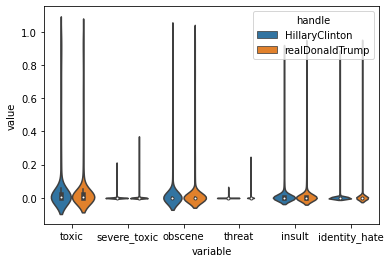

In [30]:
sns.violinplot(x='variable', y='value', hue='handle', data=melt_df)
plt.show()

We see that for each one of the categories the outliers really skew the distributions. Maybe if we clip them we can see how the "main" distributions behave:

In [31]:
melt_df['value'] = np.clip(melt_df['value'].values, 0, 0.2)

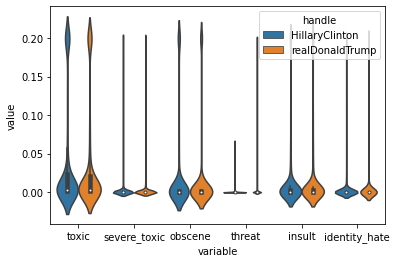

In [32]:
sns.violinplot(x='variable', y='value', hue='handle', data=melt_df)
plt.show()

Still very skewed distributions. How about one more clipping?

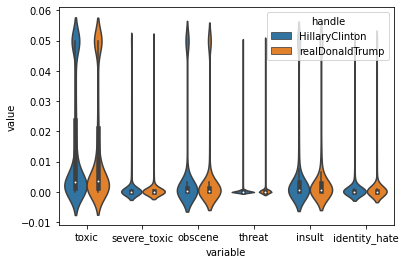

In [33]:
melt_df['value'] = np.clip(melt_df['value'].values, 0, 0.05)
sns.violinplot(x='variable', y='value', hue='handle', data=melt_df)
plt.show()

Nope, still no luck. Looks like the distributions are to some extent "scale independant". 

Based on this summary statistics, it would seem that both of them score pretty low on average for all of the "Toxic" categories. However, there do seem to be a few notable "highly probable" problemeatic tweets in each one of the six categories, with notable exception of "threat". Which, I think, is a good thing. For what it's worth (not much at all, IMHO), Hillary's tweets seem to be, on the average, toxic, severaly toxic, and obscene, while Trump's tweets score higher on the average for threat, insult, and identity hate. 

Let's see what the "worst offenders" are in for both candidates. Let's start with the most toxic Hillary tweet.

In [34]:
Hillary_predictions.loc[Hillary_predictions['toxic'].idxmax()]['text']

"We don't just believe in a country where no one is left out or left behind—we're making it a reality.\nhttps://t.co/oWVzyqrzyY"

Meh, not really toxic. Seems like the word "mad", or the high frequency of special characters, have flagged this tweet as toxic. The same tweet was also marked as the top tweet in both "severe toxic" and "obscene" categories. 

Now let's look at "threats":

In [ ]:
print(Hillary_predictions.sort_values(by=['toxic'], ascending=False)['text'].head(10).values)

["We don't just believe in a country where no one is left out or left behind—we're making it a reality.\nhttps://t.co/oWVzyqrzyY"
 "The reporting on Hillary's emails has left the basis of facts and veered into dangerous territory. https://t.co/ycp0KW7LZL"
 'Every 👈  time 👈 @realDonaldTrump 👈 makes 👈 you 👈 mad 👈 chip 👈 in👈  $1. https://t.co/dMjk7sxuSh https://t.co/yoDchxFpPZ'
 'New Yorkers speak every language, worship every faith, and hail from every continent. \n\nOur diversity is a strength, not a weakness.'
 'Every Voice is proud to endorse @HillaryClinton for president. https://t.co/S30v1eZtCm https://t.co/2YUAG4wPJu'
 'Every Republican presidential candidate would reverse @POTUS’s executive actions on immigration. https://t.co/UejylRk2Qb #FightForFamilies'
 'Donald Trump has spent his career stiffing small businesses, refusing to pay them what they’re owed. https://t.co/un2YiRLEYF'
 'Every American willing to work hard should be able to find a job that pays enough to support a fam

In [35]:
print(Hillary_predictions.sort_values(by=['severe_toxic'], ascending=False)['text'].head(10).values)

['Every 👈  time 👈 @realDonaldTrump 👈 makes 👈 you 👈 mad 👈 chip 👈 in👈  $1. https://t.co/dMjk7sxuSh https://t.co/yoDchxFpPZ'
 'New Yorkers speak every language, worship every faith, and hail from every continent. \n\nOur diversity is a strength, not a weakness.'
 "We don't just believe in a country where no one is left out or left behind—we're making it a reality.\nhttps://t.co/oWVzyqrzyY"
 'Every Voice is proud to endorse @HillaryClinton for president. https://t.co/S30v1eZtCm https://t.co/2YUAG4wPJu'
 'Every American willing to work hard should be able to find a job that pays enough to support a family.'
 'Every week, @realDonaldTrump hits a new low. https://t.co/LBrTdE2n7v'
 'Hoy es tu día de votar por Hillary. RT esto y déjale saber a tus amigos: #EstoyConElla https://t.co/YMh9aZEgDX'
 'Today is #NationalVoterRegistrationDay - I was beaten, left bloody &amp; unconscious so that every person could register and vote. Do your part.'
 'Hillary’s speaking in North Carolina on her vision to 

In [36]:
print(Hillary_predictions.sort_values(by=['obscene'], ascending=False)['text'].head(10).values)

['New Yorkers speak every language, worship every faith, and hail from every continent. \n\nOur diversity is a strength, not a weakness.'
 "We don't just believe in a country where no one is left out or left behind—we're making it a reality.\nhttps://t.co/oWVzyqrzyY"
 "The reporting on Hillary's emails has left the basis of facts and veered into dangerous territory. https://t.co/ycp0KW7LZL"
 'Every American willing to work hard should be able to find a job that pays enough to support a family.'
 '"What I see is Americans of every party, every background, every faith who believe that we are stronger together.” —@POTUS'
 'Every 👈  time 👈 @realDonaldTrump 👈 makes 👈 you 👈 mad 👈 chip 👈 in👈  $1. https://t.co/dMjk7sxuSh https://t.co/yoDchxFpPZ'
 'Every week, @realDonaldTrump hits a new low. https://t.co/LBrTdE2n7v'
 '"I don’t want Americans to feel left out and left behind. I want the American Dream to be alive and well." —Hillary\nhttps://t.co/Jds9AWz2Xw'
 'Every American should have the opp

Not really toxic, severely toxic, or obscene IMHO. Not very inspiring or humanlike either. As if a chatbot was coming up with these ...

How about threats?

In [37]:
Hillary_predictions.loc[Hillary_predictions['threat'].idxmax()]['text']

'Joe and Hillary went home to Scranton. Take a behind-the-scenes look at their visit: https://t.co/xdiqa0dbdP'

Yeah, not much going on there. As predicted with very low probability of this actually being a threat.

In [38]:
print(Hillary_predictions.sort_values(by=['threat'], ascending=False)['text'].head(10).values)

['Joe and Hillary went home to Scranton. Take a behind-the-scenes look at their visit: https://t.co/xdiqa0dbdP'
 "21 years ago @HillaryClinton's speech pushed the political discourse and forced a global dialogue on gender equality https://t.co/ie6q5yfytF"
 '"Safeguarding freedom and security is not like hosting a TV reality show. It...demands a cool head, but also a big heart." —@Madeleine'
 '“America, we will rise.” —@CoryBooker #DemsInPhilly'
 'Y ahora le toca el turno en la convención republicana a... ¡Newt Gingrich! https://t.co/lj490zwvfb'
 '"Hillary has a passion for kids and families. Donald Trump has a passion, too.\n\nIt\'s himself!" —@TimKaine https://t.co/8M7cNeLeVu'
 '"I’m with her, I’m fired up, and I can’t wait to get out there and campaign for Hillary." —@POTUS https://t.co/ptbhfpCooQ'
 'Para dejarle un mejor futuro a nuestros niños, tenemos que proteger el futuro de nuestro planeta. #DiaDeLaTierra https://t.co/BUdyIdA5lz'
 "We can't wait to welcome back President Barack

What's Hillary's worst insult?

In [39]:
Hillary_predictions.loc[Hillary_predictions['insult'].idxmax()]['text']

'Hoy es tu día de votar por Hillary. RT esto y déjale saber a tus amigos: #EstoyConElla https://t.co/YMh9aZEgDX'

Ouch. That's definitely below the belt, but in a more indirect kind of way. And yeah, insluting. Good job, predictive modeling!

Here are the top 10 "insults"

In [40]:
print(Hillary_predictions.sort_values(by=['insult'], ascending=False)['text'].head(10).values)

['Hoy es tu día de votar por Hillary. RT esto y déjale saber a tus amigos: #EstoyConElla https://t.co/YMh9aZEgDX'
 '¡Puerto Rico! Hoy es tu día de ir a votar por Hillary. Comparte esto y déjale saber a tus amigos: #EstoyConElla. https://t.co/0hjWISk8uR'
 "The reporting on Hillary's emails has left the basis of facts and veered into dangerous territory. https://t.co/ycp0KW7LZL"
 'Every 👈  time 👈 @realDonaldTrump 👈 makes 👈 you 👈 mad 👈 chip 👈 in👈  $1. https://t.co/dMjk7sxuSh https://t.co/yoDchxFpPZ'
 '"He’s spent most of his life trying to stay as far away from working people as he could.” —@POTUS on Trump https://t.co/zhjJQuMX7X'
 '"The death of Alton Sterling is a tragedy, and my prayers are with his family." —Hillary https://t.co/Yky4ZxfbLN'
 'Estoy indignado por la falta de acción para parar la violencia causada por armas de fuego. Es momento de actuar #HoldTheFloor #NoBillNoBreak'
 'Donald Trump has spent his career stiffing small businesses, refusing to pay them what they’re owed. h

Let's look at identity hate:

In [41]:
Hillary_predictions.loc[Hillary_predictions['identity_hate'].idxmax()]['text']

'“Si el lugar donde estás no tiene espacio para tu voz, no tengas miedo de crear tu propio espacio”— Hillary en #TheToast.'

Hmm, that's interesting: seem the algorithm has marked Hillary's ReTweet of Trump's tweet. Seems like there is something deep going on here. Or the algorithm is just plain unreliable. 

Let's look at the top 10 "hateful" Hillary tweets:

In [42]:
print(Hillary_predictions.sort_values(by=['identity_hate'], ascending=False)['text'].head(10).values)

['“Si el lugar donde estás no tiene espacio para tu voz, no tengas miedo de crear tu propio espacio”— Hillary en #TheToast.'
 'Y ahora le toca el turno en la convención republicana a... ¡Newt Gingrich! https://t.co/lj490zwvfb'
 'While American families suffered, Donald Trump tried to cash in. \n\nhttps://t.co/BvkHu63H1h'
 'Happy #WomensEqualityDay from @realDonaldTrump. https://t.co/YfUdtygL4h'
 'Imagine a tomorrow where hard work is honored, families are supported, communities are strong, and love trumps hate.\nhttps://t.co/PaSVdd4MH6'
 'Teen pregnancy rate at all-time low. Despite Republican opposition, access to contraception &amp; sex education works. https://t.co/fkZY4zIARd'
 'El emocionante momento cuando @lorellapraeli pudo votar por primera vez. ¡Felicitaciones!\nhttps://t.co/w2lQc1tg9o'
 '"Imagine a tomorrow where...love trumps hate.” —Hillary'
 '"We pray for those families and for the souls of all those we lost this week and all those preceding. May they rest in God’s peace" 

OK, let's move onto Trump. First, his most toxic tweet:

In [ ]:
Trump_predictions.loc[Trump_predictions['toxic'].idxmax()]['text']

'"Every American needs to say 2 simple words to every Vet they meet: THANK YOU!" John Wayne Walding \nhttps://t.co/wG8EzPHZt1'

That's just weird: there is nothign toxic about it. The same tweet has been flagged as the most severly toxic and obscene tweet as well. Not very informative.

But let's take a closer look at the top 10 flagged tweets in each one of those categories.

First toxic:

In [ ]:
print(Trump_predictions.sort_values(by=['toxic'], ascending=False)['text'].head(10).values)

['"Every American needs to say 2 simple words to every Vet they meet: THANK YOU!" John Wayne Walding \nhttps://t.co/wG8EzPHZt1'
 '"@Ma1973sk: Actually, no @FoxNews, @megynkelly has a sick obsession with Trump. Every day, every show, trashing, negative, hate.'
 "Word is that crying @GlennBeck left the GOP and doesn't have the right to vote in the Republican primary. Dumb as a rock."
 'Just left a great event in Pella. Going to church tomorrow in Muscatine, Iowa.'
 'Even though every poll, Time, Drudge etc., has me winning the debate by a lot, @FoxNews only puts negative people on. Biased - a total joke!'
 '"@arnold_ziffel: @AnnCoulter also can\'t help but notice the stock market\'s reaction as @realDonaldTrump was speaking. #UPUPUP"'
 'Jeb Bush spent more than $40,000,000 in New Hampshire to come in 4 or 5, I spent $3,000,000 to come in 1st. Big difference in capability!'
 "A massive tax increase will be necessary to fund Crooked Hillary Clinton's agenda. What a terrible (and boring) ro

Severe toxic:

In [ ]:
print(Trump_predictions.sort_values(by=['severe_toxic'], ascending=False)['text'].head(10).values)

['"Every American needs to say 2 simple words to every Vet they meet: THANK YOU!" John Wayne Walding \nhttps://t.co/wG8EzPHZt1'
 '"@CLewandowski_: Massive crowd in Pensacola, Florida! Unbelievable! THANK YOU! #VoteTrump https://t.co/9D2tsQaysd"'
 'Jeb Bush spent more than $40,000,000 in New Hampshire to come in 4 or 5, I spent $3,000,000 to come in 1st. Big difference in capability!'
 "A massive tax increase will be necessary to fund Crooked Hillary Clinton's agenda. What a terrible (and boring) rollout that was yesterday!"
 "Lyin' Ted Cruz lost all five races on Tuesday-and he was just given the jinx - a Lindsey Graham endorsement. Also backed Jeb. Lindsey got 0!"
 "American homeownership rate in Q2 2016 was 62.9% - lowest rate in 51yrs. WE will bring back the  'American Dream!' https://t.co/yI4Q8FHRjp"
 '"@arnold_ziffel: @AnnCoulter also can\'t help but notice the stock market\'s reaction as @realDonaldTrump was speaking. #UPUPUP"'
 "Word is that crying @GlennBeck left the GOP and do

Obscene:

In [ ]:
print(Trump_predictions.sort_values(by=['obscene'], ascending=False)['text'].head(10).values)

['"Every American needs to say 2 simple words to every Vet they meet: THANK YOU!" John Wayne Walding \nhttps://t.co/wG8EzPHZt1'
 '"@Ma1973sk: Actually, no @FoxNews, @megynkelly has a sick obsession with Trump. Every day, every show, trashing, negative, hate.'
 'Even though every poll, Time, Drudge etc., has me winning the debate by a lot, @FoxNews only puts negative people on. Biased - a total joke!'
 '"@CLewandowski_: Massive crowd in Pensacola, Florida! Unbelievable! THANK YOU! #VoteTrump https://t.co/9D2tsQaysd"'
 'Just left a great event in Pella. Going to church tomorrow in Muscatine, Iowa.'
 'Jeb Bush spent more than $40,000,000 in New Hampshire to come in 4 or 5, I spent $3,000,000 to come in 1st. Big difference in capability!'
 "American homeownership rate in Q2 2016 was 62.9% - lowest rate in 51yrs. WE will bring back the  'American Dream!' https://t.co/yI4Q8FHRjp"
 'Six hours left to #VoteTrump Connecticut! https://t.co/U1kbLMwhNI'
 'Wow, every poll said I won the debate last

Now how about threats?

In [ ]:
Trump_predictions.loc[Trump_predictions['threat'].idxmax()]['text']

"A massive tax increase will be necessary to fund Crooked Hillary Clinton's agenda. What a terrible (and boring) rollout that was yesterday!"

Massive tax increases? yeah, I can see how this could be viewed as threatening.

Let's take a closer look at the top 10 worst 'threat' tweets:

In [ ]:
print(Trump_predictions.sort_values(by=['threat'], ascending=False)['text'].head(10).values)

["A massive tax increase will be necessary to fund Crooked Hillary Clinton's agenda. What a terrible (and boring) rollout that was yesterday!"
 'Word is that, despite a record amount spent on negative and phony ads, I had a massive victory in Florida. Numbers out soon!'
 'While Hillary and I both won South Carolina by big margins, Repubs got far more votes with a massive increase from past cycles.GROWING PARTY'
 'A vote for Clinton-Kaine is a vote for TPP, NAFTA, high taxes, radical regulation, and massive influx of refugees.'
 'Just got back from Asheville,  North Carolina, where we had a massive rally. The spirit of the crowd was unbelievable. Thank you!  #MAGA'
 "The @WashingtonPost quickly put together a hit job book on me- comprised of copies of some of their inaccurate stories. Don't buy, boring!"
 '"@johnjohnlacca: Donald u have done a terrific job so far on the interview. Cannot wait until u r president #MegynKellyPresents'
 'In the last 2 weeks, I had $35M of negative ads agai



How about the most insulting tweet?

In [ ]:
Trump_predictions.loc[Trump_predictions['insult'].idxmax()]['text']

'Wow, you are all correct about @FoxNews - totally biased and disgusting reporting.'

Yeah, definitely insulting. On so many levels. I can't even ...

Let's take a closer look at the top 10 worst 'insult' tweets:

In [ ]:
print(Trump_predictions.sort_values(by=['insult'], ascending=False)['text'].head(10).values)

['Wow, you are all correct about @FoxNews - totally biased and disgusting reporting.'
 "Lyin' Ted Cruz lost all five races on Tuesday-and he was just given the jinx - a Lindsey Graham endorsement. Also backed Jeb. Lindsey got 0!"
 "Word is that crying @GlennBeck left the GOP and doesn't have the right to vote in the Republican primary. Dumb as a rock."
 '"@CLewandowski_: Massive crowd in Pensacola, Florida! Unbelievable! THANK YOU! #VoteTrump https://t.co/9D2tsQaysd"'
 '"Every American needs to say 2 simple words to every Vet they meet: THANK YOU!" John Wayne Walding \nhttps://t.co/wG8EzPHZt1'
 'Jeb Bush spent more than $40,000,000 in New Hampshire to come in 4 or 5, I spent $3,000,000 to come in 1st. Big difference in capability!'
 "American homeownership rate in Q2 2016 was 62.9% - lowest rate in 51yrs. WE will bring back the  'American Dream!' https://t.co/yI4Q8FHRjp"
 "The media is spending more time doing a forensic analysis of Melania's speech than the FBI spent on Hillary's emai

Seems that back then Fox News was not exactly his favorite TV network. 

And what about identity hate?

In [ ]:
Trump_predictions.loc[Trump_predictions['identity_hate'].idxmax()]['text']

'"@noamscheiber: Dow down almost 2000 pts since start of year, but still outperforming Wall Street\'s investment in Jeb. JEB wants Common Core'

That one really made me LOL. And think. Is he mocking him for his "identity" of bing Jeb? Or mommy's boy? Or W's brother? Or a weakling? All of the above? So many choices  ...

Let's take a closer look at the top 10 worst 'identity hate' tweets:

In [ ]:
print(Trump_predictions.sort_values(by=['identity_hate'], ascending=False)['text'].head(10).values)

['"@noamscheiber: Dow down almost 2000 pts since start of year, but still outperforming Wall Street\'s investment in Jeb. JEB wants Common Core'
 '"@noamscheiber: Dow down almost 2000 pts since start of year, but still outperforming Wall Street\'s investment in Jeb.'
 'Jeb failed as Jeb! He gave up and enlisted Mommy and his brother (who got us into the quicksand of Iraq). Spent $120 million.Weak-no chance!'
 "Ted Cruz, along with Jeb Bush, pushed Justice John Roberts onto the Supreme Court. Roberts could have killed ObamaCare twice, but didn't!"
 "Joe Scarborough initially endorsed Jeb Bush and Jeb crashed, then John Kasich and that didn't work. Not much power or insight!"
 '"@autumnandews08: @realDonaldTrump @JebBush Jeb is incompetent and will lose, don\'t waste your energy on that cry baby!"'
 'Tennessee GOP Poll\nhttps://t.co/hfSxKaXC42\nTrump 32.7%\nCruz 16.5%\nCarson 6.6%\nRubio 5.3%\nChristie 2.4%\nJeb 1.6%'
 '"Jeb is a weak guy." @EricTrump\nhttps://t.co/w8YuC5bApY'
 'Low ener

Seeems that Jeb really got under his skin!


In the end, this exercise shows both the strengths and limitations of algorithmic approach to toxic comment classification. Since the AUC score for the training sets is relatively high (almost 0.99 for  the top models), it is most likely that in the case human insight is even more relevant than for most other ML areas. Furthermore, even though we had a pretty large dataset to work with, it is very likely that in order to get even close to human level toxic text classification, we'd need several orders of magnitude larger training set, and/or deeper natural text understanding models. 